In [1]:
# Import libraries

import matplotlib.pyplot as plt
import pandas as pd
import warnings
from econml.sklearn_extensions.linear_model import WeightedLassoCV
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.metrics as sme
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
import sklearn.decomposition as skd
import sklearn.neighbors as skn
from sklearn.exceptions import ConvergenceWarning
from celer import GroupLassoCV
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util
from scipy.spatial import cKDTree
import nibabel as nib
import os
import pickle
from torch import nn
from rvae import VAE
from rvae import train_model
from adapt.feature_based import CORAL
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Maybe y should also be scaled? 
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function ✓
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)
# Combine CHH dataset ✓
# Implement CV and test ✓
# Print selected features ✓
# Make magnitude templates
# Sample weights ✓
# Look at segmentations by error ✓ (Appears to have most difference in red nucleus, which includes surrounding (white?) matter for underperforming cases)
# Extract features from current (1:6) eroded ROIs
# Extract features from all ROIs
# Plot segmentation variance against error for each case across all ROIs ✓
# Why does excluding the subthalamic nucleus increase the correlation (r=0.5 -> r=0.6)?
# Best performance with all ROIs: cvn=6, k=1800
# Best performance with ROIs 0:4, excluding STN: cvn=6, k=1800
# Should the pre-operative UPDRS be appended once or to each ROI? ✓
# Plot histogram of features for successful and unsuccessful predictions

In [4]:
# # Get case IDs
# case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
# lines = case_list.read()
# lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
# case_id = []
# for lines in lists:     
#     case_id.append(lines[-9:-7])

# # Load scores
# file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
# motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# # Find cases with all required scores
# subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
#                                                           'CORNELL ID',
#                                                           'OFF (pre-dbs updrs)',
#                                                           'ON (pre-dbs updrs)',
#                                                           'OFF meds ON stim 6mo')
# # Load extracted features
# npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
# phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
# roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
# n_rois = 6
# all_rois = False
# Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)

# ids = np.asarray(ID_all).astype(int)
# # Find overlap between scored subjects and feature extraction cases
# c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# # Complete case indices with respect to feature matrix
# c_cases_idx = np.in1d(ids,c_cases)
# X_all_c = X_all[c_cases_idx,:,:]
# K_all_c = K_all[c_cases_idx,:,:]
# R_all_c = R_all[c_cases_idx,:,:]
# print(R_all_c)
# # Re-index the scored subjects with respect to complete cases
# s_cases_idx = np.in1d(subs,ids[c_cases_idx])
# subsc = subs[s_cases_idx]
# pre_imp = pre_imp[s_cases_idx]
# post_imp = post_imp[s_cases_idx]
# pre_updrs_off = pre_updrs_off[s_cases_idx]
# per_change = post_imp
# # Reshape keys and ROIs
# if all_rois == True:
#     K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
#     K_all_cu[:,:,:-1] = K_all_c
#     K_all_cu[:,:,-1] = 'pre_updrs'
#     K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
#     R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
# else:
#     K = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
#     K = np.append(K,['pre_updrs'],0)
#     R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))


In [5]:
# Augment with CHH data
X0_gt = np.load('/home/ali/RadDBS-QSM/data/npy/old/X0_gt_chh_rois.npy')
df = pd.read_csv('/home/ali/RadDBS-QSM/data/xlxs/updrs_iii_chh.csv')
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]
n_rois = 6
# Data
s_directory = open('/home/ali/RadDBS-QSM/data/roi/roi_list','r').read().splitlines()
# Load
with open('/home/ali/RadDBS-QSM/data/pickles/segs_chh', "rb") as fp:  
    segs = pickle.load(fp)
    n_cases = len(segs)
with open('/home/ali/RadDBS-QSM/data/pickles/qsms_chh', "rb") as fp:  
    qsms = pickle.load(fp)
with open('/home/ali/RadDBS-QSM/data/phi/chh/Phi_mcl_gt_roi_chh', "rb") as fp:  
    Phi_gt = pickle.load(fp)
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][-2:])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
for i in range(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)                             
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 
post_updrs_iii_off =  np.asarray(df[df.columns[6]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 

per_change = (pre_updrs_iii_off-post_updrs_iii_off)/pre_updrs_iii_off
pre_updrs_off = pre_updrs_iii_off
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)
X_all_c = X_all_c[:,0:4,:]
lct_change = (pre_updrs_iii_off-pre_updrs_iii_on)/pre_updrs_iii_off
pre_imp = lct_change
subsc = subject_id_corr

Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000001 for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000002 for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000003 for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000004 for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000005 for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000006 for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000007 for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000008 for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000009 for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000010 for case 10.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000011 for case 11.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segm

In [6]:
df

,subjects,LCT,Unnamed: 2,UPDRSⅢ,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,Preoperative Off-Medicine,Preoperative On-Medicine,Postoperative Off-Medicine &Off-Stimulation\n,Postoperative Off-Medicine &On-Stimulation,Postoperative On-Medicine &On-Stimulation,NaN
1,1.0,62.26%,NaN,53,20,40,15,7,NaN
2,2.0,75.00%,NaN,32,8,26,17,10,NaN
3,3.0,51.72%,NaN,58,28,52,18,20,NaN
4,4.0,22.58%,NaN,62,48,61,36,28,NaN
5,5.0,55.88%,NaN,34,15,44,29,22,NaN
6,6.0,75.44%,NaN,57,14,55,32,16,NaN
7,7.0,84.00%,NaN,100,16,68,12,NaN,NaN
8,8.0,41.86%,NaN,43,25,48,26,26,NaN
9,9.0,72.58%,NaN,62,17,56,25,11,NaN


In [7]:
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_gls = np.zeros_like(per_change)
gerror = np.zeros_like(per_change)
alphas = np.logspace(-5,-3,100)
Ks = []
Kstg = []
w = []
wg = []
pcases = []

In [8]:
Js = []
err_var = np.zeros_like(per_change)
r = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    idy = y_train[y_train<=0.3]
    
    # Cross validation
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,test_index,pre_updrs_off,False,False,False)
    cvn = len(X0_ss0-1)
    lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,normalize=False,eps=0.1,n_jobs=1)

    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      sel = skf.SelectKBest(skf.r_regression,k=2925)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      X_test_sst = sel.transform(X_test_ss0)
      #gel = skf.RFECV(lasso,verbose=0,cv=cvn,step=100,n_jobs=-1)
      X0_ss = X0_sst#gel.fit_transform(X0_sst,y_train)
      kappa.append(np.linalg.cond(X0_ss0))
      X_test_ss = X_test_sst#gel.transform(X_test_sst)
     #Ks.append(sel.transform(K.reshape(1, -1)))
      dx0, y_n0 = cKDTree(X0_ss).query(X_test_ss, k=1)

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,n_jobs=-1,normalize=False,eps=0.1)
      try:
        lassoc = CORAL(lasso, Xt=X_test_ss, random_state=0)
        est_ls = lassoc.fit(X0_ss,y_train)
        print('Previous neighbor',str(y_train[y_n0]),'with distance',str(np.round(dx0,5)))
        # If domain='tgt', apply transform to X0_ss (source data)
        dx, y_n = cKDTree(X0_ss).query(lassoc.transform(X_test_ss,domain='src'), k=1)
        print('New neighbor',str(y_train[y_n]),'with distance',str(np.round(dx,5)))
        coral = 1
      except:
        y_n = y_n0
        print('CORAL failed on test case with covariance:',np.cov(X_test_ss0))
        est_ls = lasso.fit(X0_ss,y_train)
        coral = 0
    # Reconstruct nearest neighbor
    r[j] = est_ls.predict(X0_ss[y_n,:])
    err_var[j] = np.mean(abs(est_ls.predict(X0_ss)-y_train))
    rerror[j] = np.abs(r[j]-y_train[y_n])
    #s.append(est_ls.score(X0_ss,y_train))
    results_ls[j] = est_ls.predict(X_test_ss)
    # If reconstruction error is too high, use nearest neighbor
    if rerror[j] > 1 and coral == 1:
      y_n = y_n0
      print('Refitting due to high reconstruction error after CORAL which estimated:',
            str(np.round(results_ls[j],2)),'with error',str(np.round(rerror[j],9)))
      est_ls = lasso.fit(X0_ss,y_train)
      results_ls[j] = est_ls.predict(X_test_ss)
      rerror[j] = np.abs(r[j]-y_train[y_n])
      if rerror[j] > 0.5: 
        results_ls[j] = y_train[y_n]
        print('Using nearest neighbor after estimating:',str(results_ls[j]))
    else:
      if rerror[j] > 0.5:
        print('Using nearest neighbor after high reconstruction error and CORAL failure')
        y_n = y_n0
        results_ls[j] = y_train[y_n]

    print('Lasso predicts',str(np.round(results_ls[j],2)),
              'for case with',str(np.round(per_change[j],2)),
             # 'with regularization',str(est_ls.alpha_),
              'with reconstruction error',str(np.round(rerror[j],9)),
              'maximum error',str(np.round(err_var[j],9)),
              'and neighbor',str(np.round(y_train[y_n],2).item()),
              'and condition number',str(kappa[j]))
    gerror[j] = (abs(results_ls[j]-y_test))
        

  


Fit transform...
Previous covariance difference: 0.537508
New covariance difference: 0.169345
Fit Estimator...
Previous neighbor [0.8125]
New neighbor [0.77777778]
Using nearest neighbor after high reconstruction error and CORAL failure
Lasso predicts 0.81 for case with 0.72 with reconstruction error 0.52158816 maximum error 0.196891351 and neighbor 0.81 and condition number 2032616339520.4373
Fit transform...
Previous covariance difference: 0.495951
New covariance difference: 0.155485
Fit Estimator...
Previous neighbor [0.09677419]
New neighbor [0.31521739]
Lasso predicts 0.3 for case with 0.47 with reconstruction error 0.333487174 maximum error 0.208862897 and neighbor 0.32 and condition number 1741441259039.065
Fit transform...
Previous covariance difference: 1.734178
New covariance difference: 0.567856
Fit Estimator...
Previous neighbor [0.48148148]
New neighbor [0.77777778]
Lasso predicts 0.62 for case with 0.69 with reconstruction error 0.38816833 maximum error 0.166953618 and ne

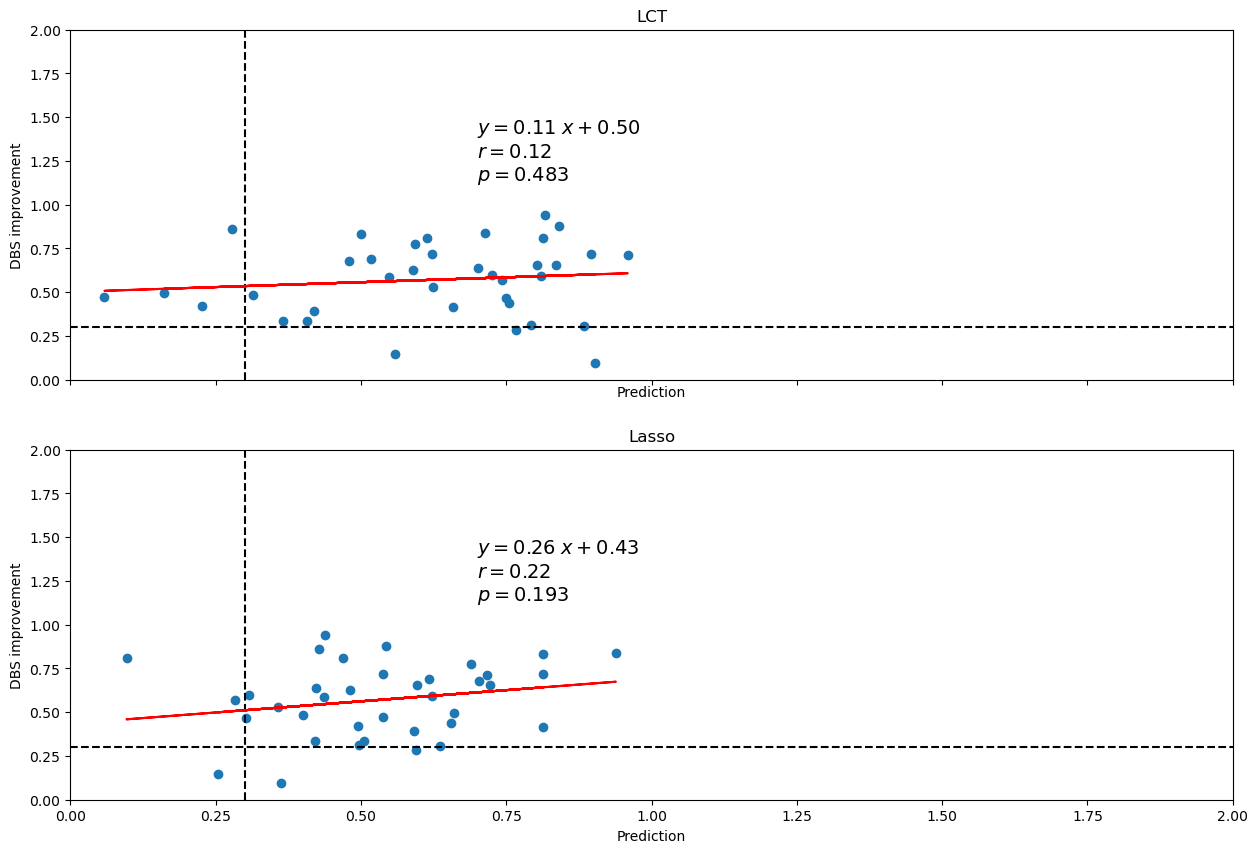

In [11]:
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(30,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

In [10]:
# fig,ax = plt.subplots(3,2,sharex=True,sharey=True)
# plt.style.use('dark_background')
# plt.rcParams["figure.figsize"] = (10,10)
# ax[0,0].scatter(V[:,0]/1000,gerror)
# ax[0,0].set_title('Right red nucleus')
# ax[0,1].scatter(V[:,1]/1000,gerror)
# ax[0,1].set_title('Left red nucleus')
# ax[1,0].scatter(V[:,2]/1000,gerror)
# ax[1,0].set_title('Right substantia nigra')
# ax[1,1].scatter(V[:,3]/1000,gerror)
# ax[1,1].set_title('Left substantia nigra')
# ax[2,0].scatter(V[:,4]/1000,gerror)
# ax[2,0].set_title('Right subthalamic nuclei')
# ax[2,1].scatter(V[:,5]/1000,gerror)
# ax[2,1].set_title('Left subthalamic nuclei')
# plt.setp(ax[-1, :], xlabel='Variance');
# plt.setp(ax[:, 0], ylabel='Error');